In [ ]:
!nvidia-smi

Thu Nov  6 16:03:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Paths for dataset folders
input_dataset = "/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
output_dataset = "/content/drive/MyDrive/Colab Notebooks/dataset2"

# Ensure the output dataset directory exists
if os.path.exists(output_dataset):
    shutil.rmtree(output_dataset)  # Remove old dataset if it exists
os.makedirs(output_dataset)

# Define basic augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Required class names
list1=os.listdir(input_dataset)
#required_classes = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]

# Process each class folder
for class_name in tqdm(list1, desc="Processing Classes"):
    class_path = os.path.join(input_dataset, class_name)

    if not os.path.exists(class_path):
        print(f"❌ Skipping {class_name}, folder not found.")
        continue

    # Create the new output class folder
    output_class_path = os.path.join(output_dataset, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    # Load all images from the class folder
    images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('png', 'jpg', 'jpeg'))]

    # Generate exactly 1000 augmented images
    num_images_generated = 0
    image_index = 0

    with tqdm(total=1000, desc=f"Augmenting {class_name}", leave=False) as pbar:
        while num_images_generated < 1000:
            img_path = images[image_index % len(images)]  # Loop through existing images
            img = load_img(img_path)  # Load image
            img = img.resize((100, 100))  # Resize to 100x100
            img_array = img_to_array(img)  # Convert to array
            img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions

            # Generate augmented images
            aug_iter = datagen.flow(img_array, batch_size=1)
            for _ in range(min(1000 - num_images_generated, 5)):  # Generate up to 5 images per iteration
                augmented_img = array_to_img(next(aug_iter)[0])  # Convert back to image
                augmented_img = augmented_img.resize((100, 100))  # Resize again to ensure size
                save_path = os.path.join(output_class_path, f"aug_{num_images_generated}.png")
                augmented_img.save(save_path)  # Save image
                num_images_generated += 1
                pbar.update(1)  # Update progress bar

            image_index += 1  # Move to the next image

print("✅ Data augmentation complete. Augmented dataset saved in 'dataset7'.")


Processing Classes: 100%|██████████| 9/9 [04:53<00:00, 32.57s/it]

✅ Data augmentation complete. Augmented dataset saved in 'dataset7'.


In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def preprocess_and_save_with_subclasses2(input_dir, output_dir, target_size=(100,100)):
    """
    Preprocess images from input directory (with subclasses) and save to output directory.
    - Maintains the original folder structure (subclasses).
    - Applies image preprocessing: grayscale, CLAHE, Gaussian blur, Canny edge detection, and overlays edges in red.
    """
    # Initialize CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    list1=os.listdir(input_dir)

    for subclass in list1:
        subclass_path = os.path.join(input_dir, subclass)
        if not os.path.isdir(subclass_path):
            continue  # Skip files, only process folders

        # Create corresponding subclass folder in the output directory
        output_subclass_path = os.path.join(output_dir, subclass)
        if not os.path.exists(output_subclass_path):
            os.makedirs(output_subclass_path)

        # Process each image in the subclass folder
        for image_name in tqdm(os.listdir(subclass_path), desc=f"Processing {subclass}"):
            image_path = os.path.join(subclass_path, image_name)
            image = cv2.imread(image_path)

            if image is None:
                continue  # Skip invalid files

            # Resize image
            image = cv2.resize(image, target_size)

            # Convert to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply CLAHE for contrast enhancement
            clahe_enhanced = clahe.apply(gray)

            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(clahe_enhanced, (5, 5), 0)

            # Apply Canny edge detection
            edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

            # Create an RGB edge map (edges in red)
            edges_colored = np.zeros_like(image)  # Create a black RGB image
            edges_colored[:, :, 2] = edges  # Set red channel to edges

            # Overlay the edges onto the original image
            combined = cv2.addWeighted(image, 0.8, edges_colored, 0.5, 0)

            # Save the processed image to the corresponding output folder
            output_path = os.path.join(output_subclass_path, image_name)
            cv2.imwrite(output_path, combined)


In [ ]:
# Define input and output directories
input_directory = '/content/drive/MyDrive/Colab Notebooks/notebook/dataset2'  # Contains subclass folders
output_directory = '/content/drive/MyDrive/Colab Notebooks/notebook/dataset_preprocessed'  # Preprocessed images will be saved here

# Run preprocessing
preprocess_and_save_with_subclasses2(input_directory, output_directory)


Processing actinic keratosis: 100%|██████████| 1000/1000 [00:19<00:00, 51.55it/s]


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import os
import random

In [ ]:
import os
import cv2
import numpy as np

def load_dataset(path_dataset, target_size=(100,100)):
    dataset = []
    labels = []

    # Iterate over all folders in dataset_path
    for label in os.listdir(path_dataset):
        class_path = os.path.join(path_dataset, label)

        # check if the directory exists
        if os.path.isdir(class_path):
            # Initialize a counter for images in each class
            images_counter = 0

            # Iterate over all images in folder/class
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)

                # Load image with OpenCV
                image = cv2.imread(image_path)

                # Check if the image was loaded successfully
                if image is not None:
                    # Resize the image
                    image = cv2.resize(image, target_size)
                    # Get image dimensions
                    (h, w) = image.shape[:2]

                    # Step 1: Apply random rotation between 0 to 5 degrees
                    angle = random.uniform(0, 5)  # Random angle between 0 and 5 degrees
                    center = (w // 2, h // 2)  # Center of the image
                    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)  # Rotation matrix
                    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))

                    # Step 2: Apply right-to-left flip
                    image = cv2.flip(rotated_image, 1)  # Flip horizontally
                    # Add image and label to dataset
                    dataset.append(image)
                    labels.append(label)


                else:
                    print(f"Error loading image: {image_path}")

    return np.array(dataset), np.array(labels)

dataset_path = "/content/drive/MyDrive/Colab Notebooks/notebook/dataset_preprocessed"
dataset, labels = load_dataset(dataset_path)

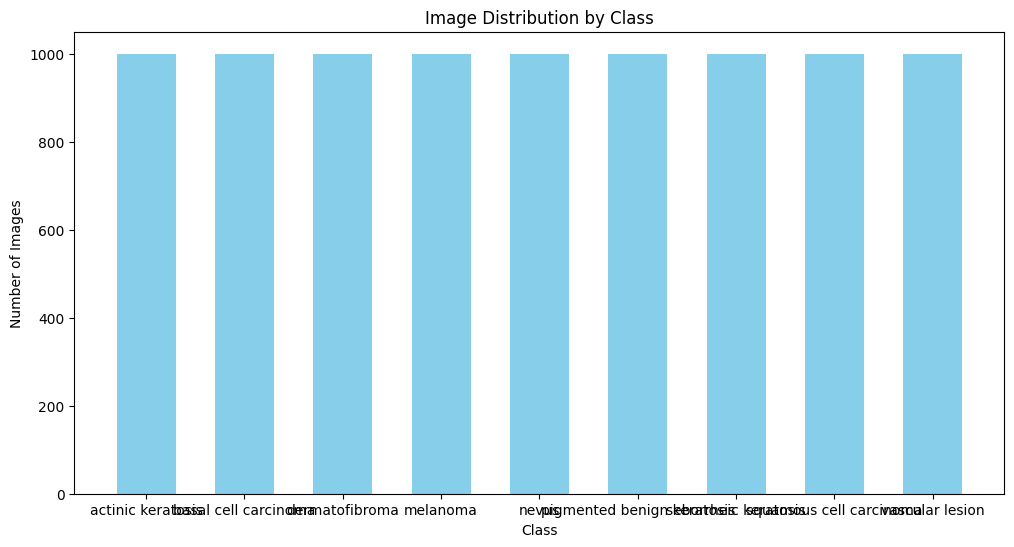

In [ ]:
unique_labels, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(unique_labels, counts))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(class_counts.keys(), class_counts.values(), color='skyblue', width=0.6)

ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Image Distribution by Class')

plt.show()

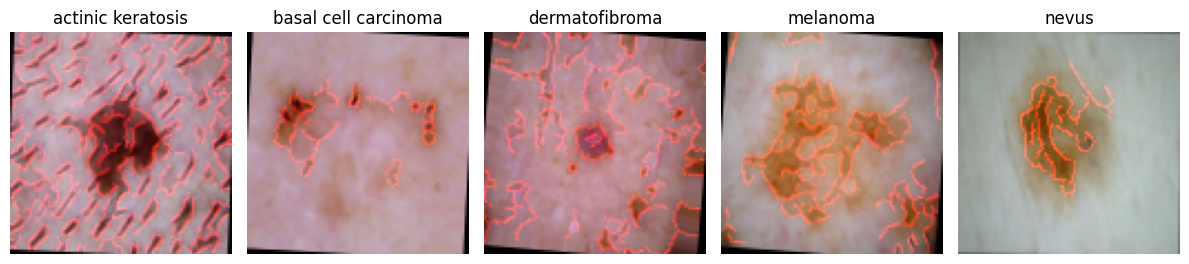

In [ ]:
import random
import matplotlib.pyplot as plt

def show_samples(dataset, labels, classes, num_samples):
    plt.figure(figsize=(12, 6))

    for i, class_name in enumerate(classes[:num_samples]):  # Show only the first num_samples classes
        indices_class = np.where(labels == class_name)[0]
        sample_index = random.choice(indices_class)

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(dataset[sample_index], cv2.COLOR_BGR2RGB))
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


unique_classes = np.unique(labels)
show_samples(dataset, labels, unique_classes, num_samples=5)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode labels into numbers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)



X_train, X_temp, y_train, y_temp = train_test_split(dataset, encoded_labels, test_size=0.2, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


def preprocess_image(image):
    resized_image = cv2.resize(image, (100,100))

    normalized_image = resized_image / 255.0
    return normalized_image


X_train = np.array([preprocess_image(image) for image in X_train])
X_test = np.array([preprocess_image(image) for image in X_test])
X_val = np.array([preprocess_image(image) for image in X_val])


print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (7200, 100, 100, 3)
Shape of X_val: (900, 100, 100, 3)
Shape of X_test: (900, 100, 100, 3)
Shape of y_train: (7200,)
Shape of y_val: (900,)
Shape of y_test: (900,)


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop
import numpy as np

# Define the number of classes
num_classes = len(np.unique(labels))

mobilenet_model = MobileNet(input_shape=(100, 100, 3), include_top=False, weights='imagenet')

x = GlobalAveragePooling2D()(mobilenet_model.output)

x = Dense(128, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(32, kernel_regularizer=l1(0.0001), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

outputs = Dense(units=num_classes, activation='softmax')(x)
model = models.Model(inputs=mobilenet_model.input, outputs=outputs)

custom_optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))


/tmp/ipython-input-1880990433.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNet(input_shape=(100, 100, 3), include_top=False, weights='imagenet')


Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.1640 - loss: 3.2507 - val_accuracy: 0.4033 - val_loss: 2.3124
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3570 - loss: 2.4440 - val_accuracy: 0.5456 - val_loss: 1.9162
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4640 - loss: 2.0903 - val_accuracy: 0.6422 - val_loss: 1.6519
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5565 - loss: 1.8589 - val_accuracy: 0.7111 - val_loss: 1.5075
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6494 - loss: 1.6349 - val_accuracy: 0.7700 - val_loss: 1.3288
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7190 - loss: 1.4283 - val_accuracy: 0.7867 - val_loss: 1.2538
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7966 - loss: 1.2544 - val_accuracy: 0.8478 - val_loss: 1.0713
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8502 - loss: 1.1024 - val_acc

In [ ]:
# Save the weights of the model to a file
model.save('/content/drive/MyDrive/skin_cancer_models/mobilenet_skin_cancer_model.h5')
model.save('/content/drive/MyDrive/skin_cancer_models/mobilenet_skin_cancer_model.keras')
model.save('/content/drive/MyDrive/skin_cancer_models/mobilenet_skin_cancer_model.weights.h5')
model.save('/content/drive/MyDrive/skin_cancer_models/mobilenet_skin_cancer_model.weights.keras')

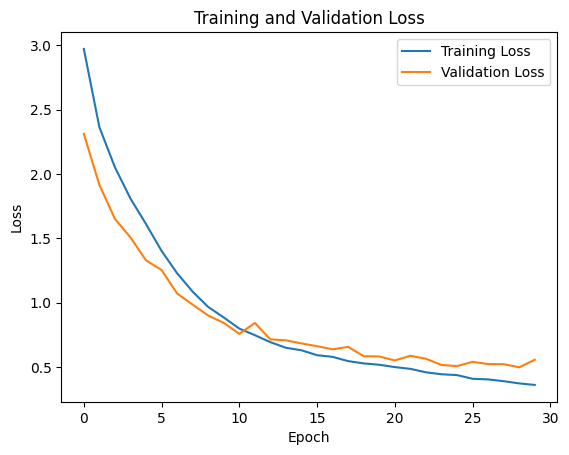

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

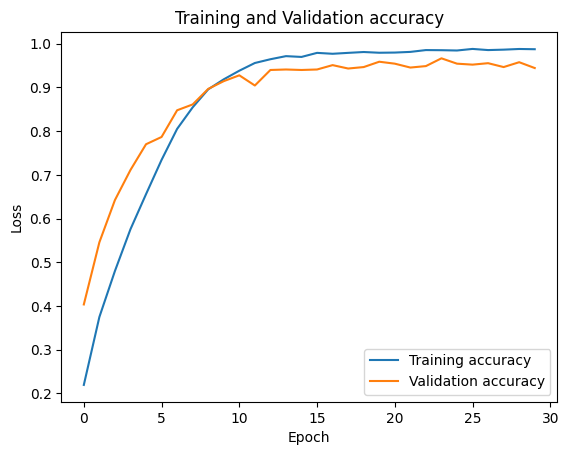

In [ ]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step
Test Accuracy: 0.9389


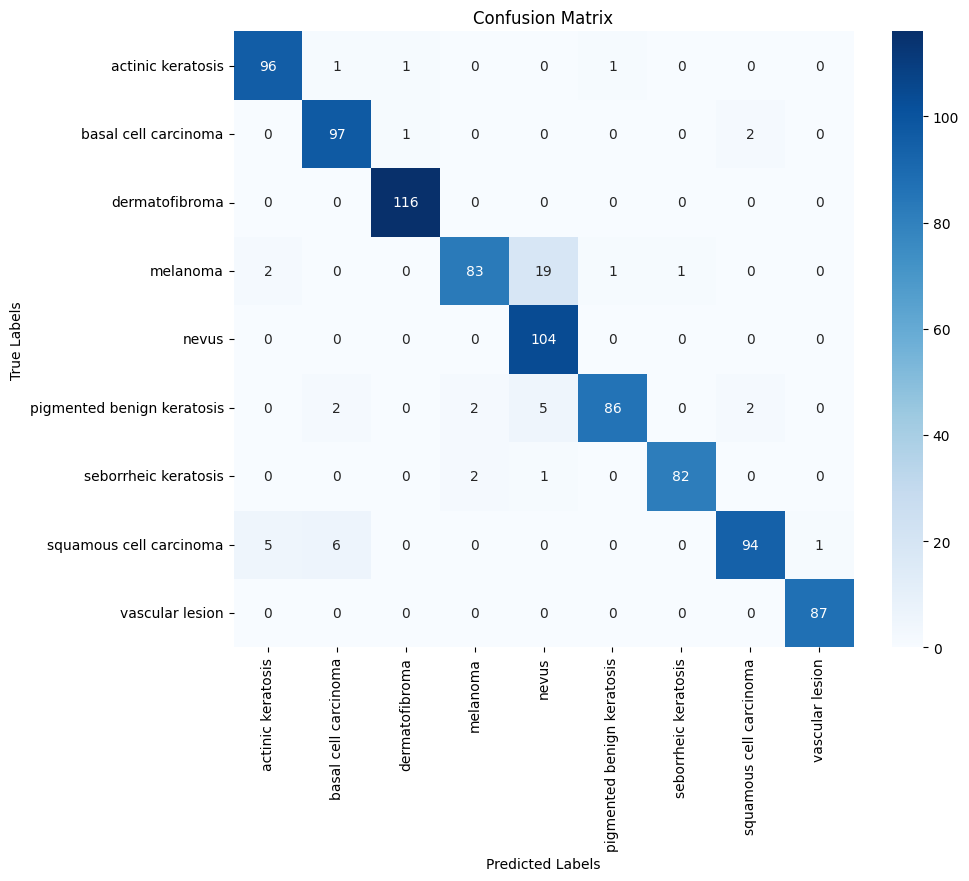

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis     0.9320    0.9697    0.9505        99
      basal cell carcinoma     0.9151    0.9700    0.9417       100
            dermatofibroma     0.9831    1.0000    0.9915       116
                  melanoma     0.9540    0.7830    0.8601       106
                     nevus     0.8062    1.0000    0.8927       104
pigmented benign keratosis     0.9773    0.8866    0.9297        97
      seborrheic keratosis     0.9880    0.9647    0.9762        85
   squamous cell carcinoma     0.9592    0.8868    0.9216       106
           vascular lesion     0.9886    1.0000    0.9943        87

                  accuracy                         0.9389       900
                 macro avg     0.9448    0.9401    0.9398       900
              weighted avg     0.9436    0.9389    0.9385       900



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and predicted classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = y_test

# Calculate test accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_, digits=4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_97']
Received: inputs=Tensor(shape=(1, 100, 100, 3))
  warnings.warn(msg)


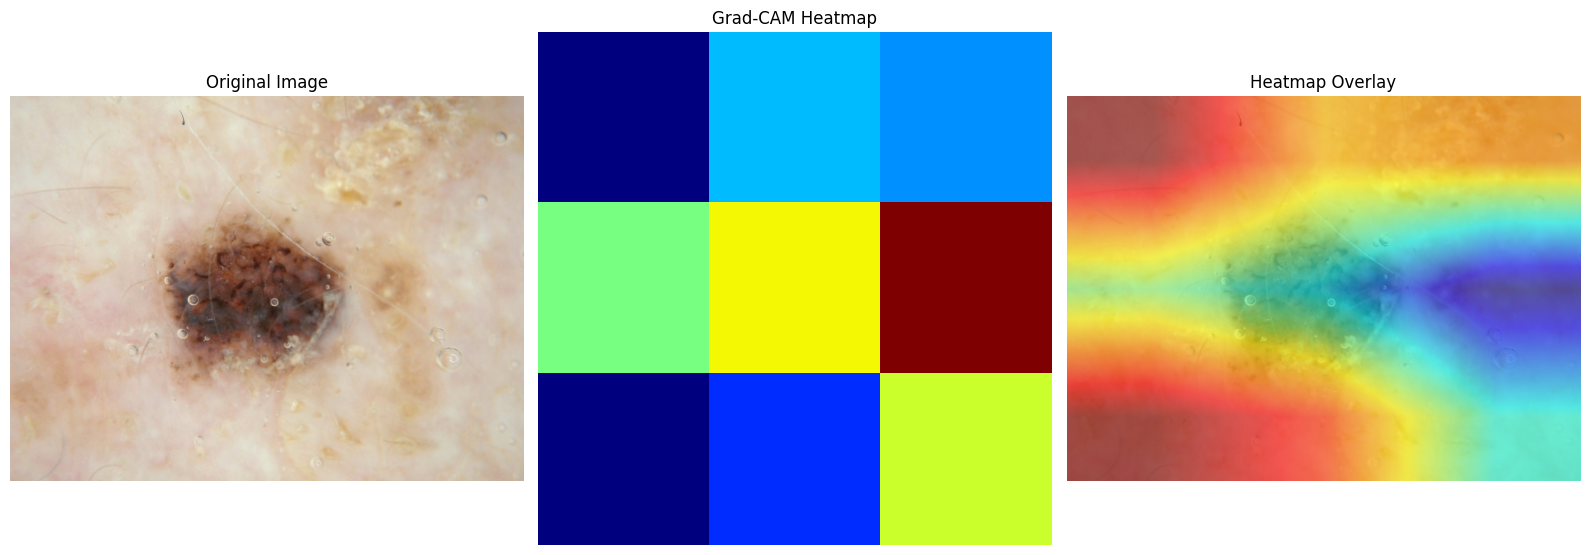

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

def generate_gradcam_heatmap(model, image, class_idx, last_conv_layer_name):
    # Build a model that maps input image to activations of last conv layer & predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get activation map of the last conv layer
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap_on_image(heatmap, original_image, alpha=0.6, colormap=cv2.COLORMAP_JET):
    # Resize heatmap to match original image size
    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

    # Convert heatmap to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)

    # Overlay heatmap on original image
    overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed_image

# Provide the image path
image_path = "/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010810.jpg"

# Load and preprocess the image
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image = cv2.resize(original_image, (100,100)) / 255.0  # Resize to match MobileNet input shape

# Get the predicted class index
class_idx = np.argmax(model.predict(np.expand_dims(image, axis=0)))

# Generate the Grad-CAM heatmap using MobileNet's last convolutional layer
heatmap = generate_gradcam_heatmap(model, image, class_idx, last_conv_layer_name='conv_pw_13_relu')

# Overlay the heatmap on the original image
overlayed_image = overlay_heatmap_on_image(heatmap, original_image)

# Plot the results
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis("off")

# Heatmap overlaid on original image
plt.subplot(1, 3, 3)
plt.imshow(overlayed_image)
plt.title("Heatmap Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
